In [1]:
import os
from pathlib import Path
import tempfile

import numpy as np
import matplotlib.pyplot as plt

try:
    import cupy as cp
    if cp.cuda.is_available():
        print("GPU is available")
        print("GPU:", cp.cuda.runtime.getDeviceProperties(0)["name"])
    else:
        print("CuPy installed but no GPU detected")
except Exception as e:
    print(f"GPU not available: {e}")
    print("Running on CPU only")

from IPython.display import HTML, display
import h5py
import tdgl
from tdgl.geometry import box, circle
from tdgl.visualization.animate import create_animation

plt.rcParams["figure.figsize"] = (5, 4)
tempdir = tempfile.TemporaryDirectory()



GPU is available
GPU: b'NVIDIA GeForce GTX 1050 Ti'


c:\Users\Logan\OneDrive\Desktop\Electrodynamics_II\.pixi\envs\default\Lib\site-packages\cupyx\jit\_interface.py:173: FutureWarning: cupyx.jit.rawkernel is experimental. The interface can change in the future.
  cupy._util.experimental('cupyx.jit.rawkernel')


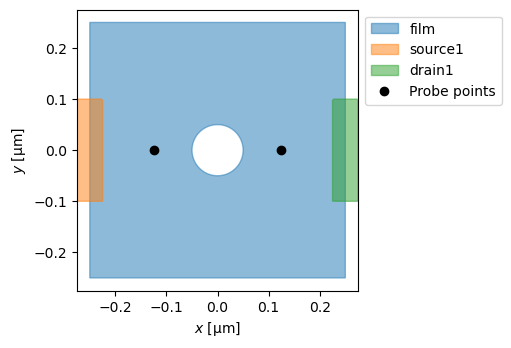

In [2]:
physical_params = {
    "length_units": "um",
    "xi": 0.1,
    "london_lambda": 2,
    "thickness": 0.1,
    "gamma": 1,
    "width": 0.5,
    "height": 0.5,
    "terminal_size": (0.05, 0.2),
    "hole_radius": 0.05,
}

layer = tdgl.Layer(
    coherence_length=physical_params["xi"],
    london_lambda=physical_params["london_lambda"],
    thickness=physical_params["thickness"],
    gamma=physical_params["gamma"],
)

main_film = tdgl.Polygon(
    "film",
    points=box(physical_params["width"], physical_params["height"]),
).resample(401)
hole = tdgl.Polygon(
    "hole",
    points=circle(physical_params["hole_radius"], center=(0, 0)),
)

term_width, term_height = physical_params["terminal_size"]
source1 = (
    tdgl.Polygon("source1", points=box(term_width, term_height))
    .translate(-physical_params["width"] / 2, 0)
    .buffer(0)
)
drain1 = (
    tdgl.Polygon("drain1", points=box(term_width, term_height))
    .translate(physical_params["width"] / 2, 0)
    .buffer(0)
)

probe_points = [
    ((-physical_params["width"] * 0.25, 0.0), (physical_params["width"] * 0.25, 0.0))
]

device = tdgl.Device(
    "2currents",
    layer=layer,
    film=main_film,
    holes=[hole],
    terminals=[source1, drain1],
    length_units=physical_params["length_units"],
    probe_points=probe_points,
)
fig, ax = device.draw()

Constructing Voronoi polygons: 100%|██████████| 2583/2583 [00:01<00:00, 1436.01it/s]


num_sites,2583
num_elements,4666
min_edge_length,2.333e-03
max_edge_length,2.352e-02
mean_edge_length,9.886e-03
min_area,3.266e-06
max_area,3.347e-04
mean_area,9.376e-05
coherence_length,1.000e-01
length_units,um


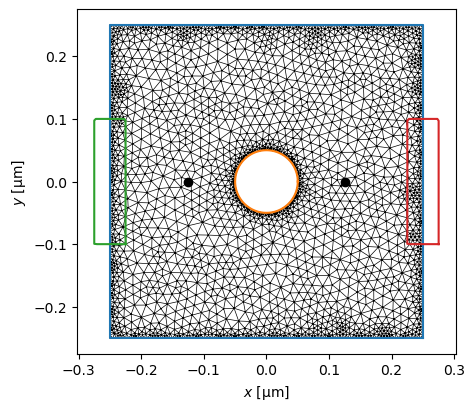

In [3]:
device.make_mesh(max_edge_length=physical_params["xi"] / 4, smooth=100)
display(device.mesh_stats())
fig, ax = device.plot(mesh=True, legend=False)

## Current Sweep
Reuse the previously computed sweep cache (`two_terminal_1gap_sweep`).

In [4]:
currents = np.linspace(0.0, 12.0, 600)
voltages = []
times = []
solutions = []

sweep_dir = Path("../datasets/two_terminal_1gap_sweep")
sweep_dir.mkdir(exist_ok=True)

options = tdgl.SolverOptions(
    solve_time=300,
    output_file=os.path.join(tempdir.name, "weak-link-1gap-current.h5"),
    field_units="mT",
    current_units="uA",
)
applied_vector_potential = tdgl.sources.constant.ConstantField(
    30, field_units=options.field_units, length_units=device.length_units
)

for idx, bias in enumerate(currents):
    save_path = sweep_dir / f"bias_{idx:04d}.npz"
    if save_path.exists():
        cached = np.load(save_path)
        voltages.append(cached["voltage"])
        times.append(cached["time"])
        solutions.append(None)
        continue

    sweep_solution = tdgl.solve(
        device=device,
        options=options,
        applied_vector_potential=applied_vector_potential,
        terminal_currents=dict(source1=bias, drain1=-bias),
    )

    voltage_trace = sweep_solution.dynamics.voltage()
    time_trace = sweep_solution.dynamics.time

    voltages.append(voltage_trace)
    times.append(time_trace)
    solutions.append(sweep_solution)

    np.savez_compressed(
        save_path,
        current=bias,
        time=time_trace,
        voltage=voltage_trace,
    )

## Field Bias Snapshot
Run one extra bias point for current streamlines.

Simulating:  10%|▉         | 29/300 [00:16<02:34,  1.76tau/s ]



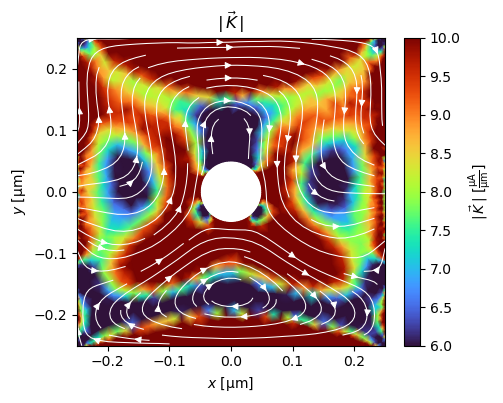

In [5]:
zero_current_solution = tdgl.solve(
    device=device,
    options=options,
    applied_vector_potential=applied_vector_potential,
    terminal_currents=dict(source1=2, drain1=-2),
)
fig, ax = zero_current_solution.plot_currents(min_stream_amp=0.075, vmin=6, vmax=10, cmap="turbo")

## Current Streamline Snapshots
Visualize supercurrent flow patterns for different bias currents (0-10 μA)

Output file already exists. Renaming to C:\Users\Logan\AppData\Local\Temp\tmp21tdqlut\weak-link-1gap-current-1.h5.


Generating current streamline plots...
  Processing I = 0.00 μA (1/11)


Simulating: 100%|█████████▉| 300/300 [02:09<00:00,  2.32tau/s ]

Output file already exists. Renaming to C:\Users\Logan\AppData\Local\Temp\tmp21tdqlut\weak-link-1gap-current-2.h5.
Output file already exists. Renaming to C:\Users\Logan\AppData\Local\Temp\tmp21tdqlut\weak-link-1gap-current-2.h5.


  Processing I = 1.00 μA (2/11)


Simulating: 100%|█████████▉| 300/300 [02:12<00:00,  2.27tau/s ]

Output file already exists. Renaming to C:\Users\Logan\AppData\Local\Temp\tmp21tdqlut\weak-link-1gap-current-3.h5.
Output file already exists. Renaming to C:\Users\Logan\AppData\Local\Temp\tmp21tdqlut\weak-link-1gap-current-3.h5.


  Processing I = 2.00 μA (3/11)


Simulating: 100%|█████████▉| 300/300 [02:10<00:00,  2.30tau/s ]

Output file already exists. Renaming to C:\Users\Logan\AppData\Local\Temp\tmp21tdqlut\weak-link-1gap-current-4.h5.
Output file already exists. Renaming to C:\Users\Logan\AppData\Local\Temp\tmp21tdqlut\weak-link-1gap-current-4.h5.


  Processing I = 3.01 μA (4/11)


Simulating: 100%|█████████▉| 300/300 [02:13<00:00,  2.25tau/s ]

Output file already exists. Renaming to C:\Users\Logan\AppData\Local\Temp\tmp21tdqlut\weak-link-1gap-current-5.h5.
Output file already exists. Renaming to C:\Users\Logan\AppData\Local\Temp\tmp21tdqlut\weak-link-1gap-current-5.h5.


  Processing I = 4.01 μA (5/11)


Simulating: 100%|█████████▉| 300/300 [02:11<00:00,  2.28tau/s ]

Output file already exists. Renaming to C:\Users\Logan\AppData\Local\Temp\tmp21tdqlut\weak-link-1gap-current-6.h5.
Output file already exists. Renaming to C:\Users\Logan\AppData\Local\Temp\tmp21tdqlut\weak-link-1gap-current-6.h5.


  Processing I = 5.01 μA (6/11)


Simulating: 100%|█████████▉| 300/300 [02:10<00:00,  2.30tau/s ]

Output file already exists. Renaming to C:\Users\Logan\AppData\Local\Temp\tmp21tdqlut\weak-link-1gap-current-7.h5.
Output file already exists. Renaming to C:\Users\Logan\AppData\Local\Temp\tmp21tdqlut\weak-link-1gap-current-7.h5.


  Processing I = 5.99 μA (7/11)


Simulating: 100%|█████████▉| 300/300 [02:09<00:00,  2.32tau/s ]

Output file already exists. Renaming to C:\Users\Logan\AppData\Local\Temp\tmp21tdqlut\weak-link-1gap-current-8.h5.
Output file already exists. Renaming to C:\Users\Logan\AppData\Local\Temp\tmp21tdqlut\weak-link-1gap-current-8.h5.


  Processing I = 6.99 μA (8/11)


Simulating: 100%|█████████▉| 300/300 [02:09<00:00,  2.31tau/s ]

Output file already exists. Renaming to C:\Users\Logan\AppData\Local\Temp\tmp21tdqlut\weak-link-1gap-current-9.h5.
Output file already exists. Renaming to C:\Users\Logan\AppData\Local\Temp\tmp21tdqlut\weak-link-1gap-current-9.h5.


  Processing I = 7.99 μA (9/11)


Simulating: 100%|█████████▉| 300/300 [02:11<00:00,  2.28tau/s ]

Output file already exists. Renaming to C:\Users\Logan\AppData\Local\Temp\tmp21tdqlut\weak-link-1gap-current-10.h5.
Output file already exists. Renaming to C:\Users\Logan\AppData\Local\Temp\tmp21tdqlut\weak-link-1gap-current-10.h5.


  Processing I = 8.99 μA (10/11)


Simulating: 100%|█████████▉| 300/300 [02:13<00:00,  2.24tau/s ]

Output file already exists. Renaming to C:\Users\Logan\AppData\Local\Temp\tmp21tdqlut\weak-link-1gap-current-11.h5.
Output file already exists. Renaming to C:\Users\Logan\AppData\Local\Temp\tmp21tdqlut\weak-link-1gap-current-11.h5.


  Processing I = 10.00 μA (11/11)


Simulating: 100%|█████████▉| 300/300 [02:15<00:00,  2.21tau/s ]



Done!


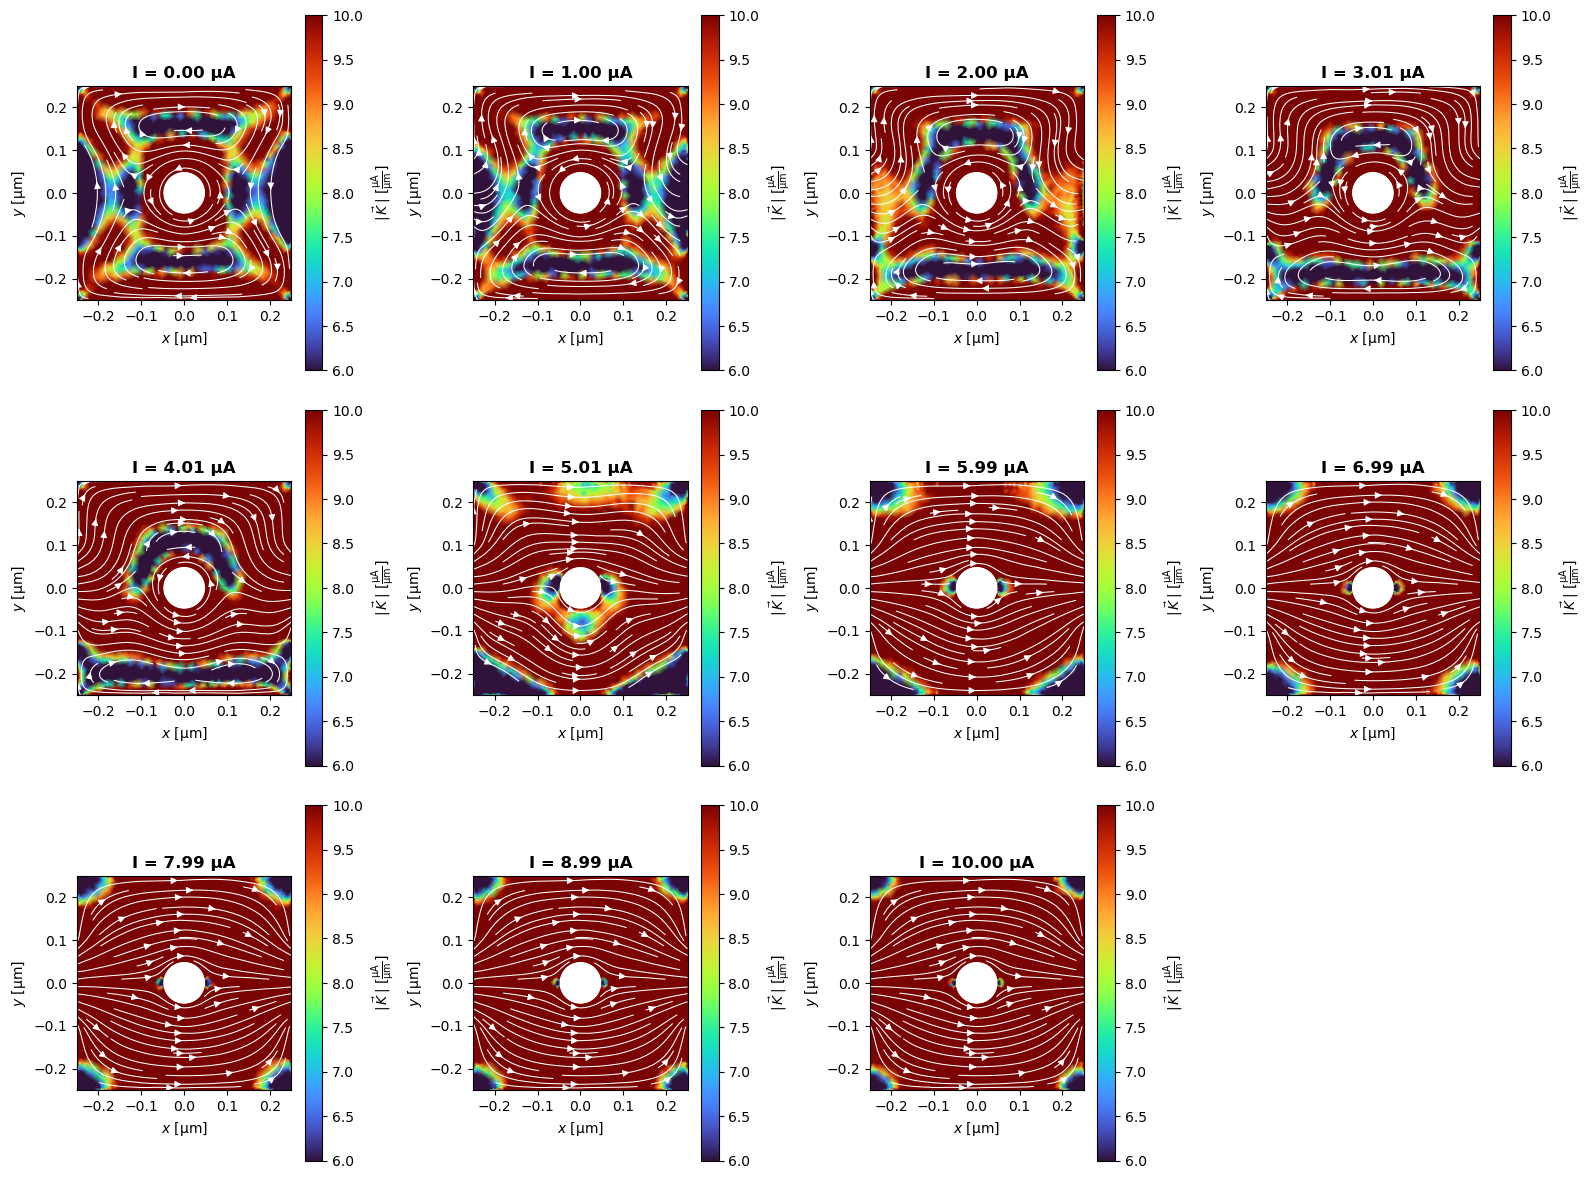

In [ ]:
# Prepare solutions for current flow visualizations at I = 0 to 10 μA
target_currents_viz = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
indices_viz = [np.abs(currents - val).argmin() for val in target_currents_viz]

streamline_solutions = []
streamline_currents = []
print("Preparing solutions for streamline plots...")
for idx, current_val in zip(indices_viz, target_currents_viz):
    sol = solutions[idx]
    if sol is None:
        print(f"  Solving for I = {currents[idx]:.2f} μA")
        sol = tdgl.solve(
            device=device,
            options=options,
            applied_vector_potential=applied_vector_potential,
            terminal_currents=dict(source1=currents[idx], drain1=-currents[idx]),
        )
        solutions[idx] = sol
    else:
        print(f"  Loaded cached solution for I = {currents[idx]:.2f} μA")
    streamline_solutions.append(sol)
    streamline_currents.append(currents[idx])

print("All solutions ready.")

In [ ]:
# Plot current streamlines with a shared colormap reference
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

cmap_name = "turbo"
vmin, vmax = 6, 10

fig, axes = plt.subplots(3, 4, figsize=(16, 12))
axes = axes.flatten()

scalar_mappable = ScalarMappable(norm=Normalize(vmin=vmin, vmax=vmax), cmap=cmap_name)

print("Rendering streamline plots...")
for ax, sol, current_val in zip(axes, streamline_solutions, streamline_currents):
    sol.plot_currents(
        min_stream_amp=0.075,
        vmin=vmin,
        vmax=vmax,
        cmap=cmap_name,
        ax=ax,
    )
    ax.set_title(f"I = {current_val:.2f} μA", fontsize=12, fontweight="bold")

# Hide any unused subplots
for ax in axes[len(streamline_solutions):]:
    ax.axis("off")

fig.colorbar(
    scalar_mappable,
    ax=axes.tolist(),
    fraction=0.03,
    pad=0.02,
    label="|K| (normalized)",
)

plt.tight_layout()
print("Done!")
plt.show()

## I-V Extraction
Reuse `series2` directory for stored traces and plot the averaged I-V curve.

(0.0, 1.5)

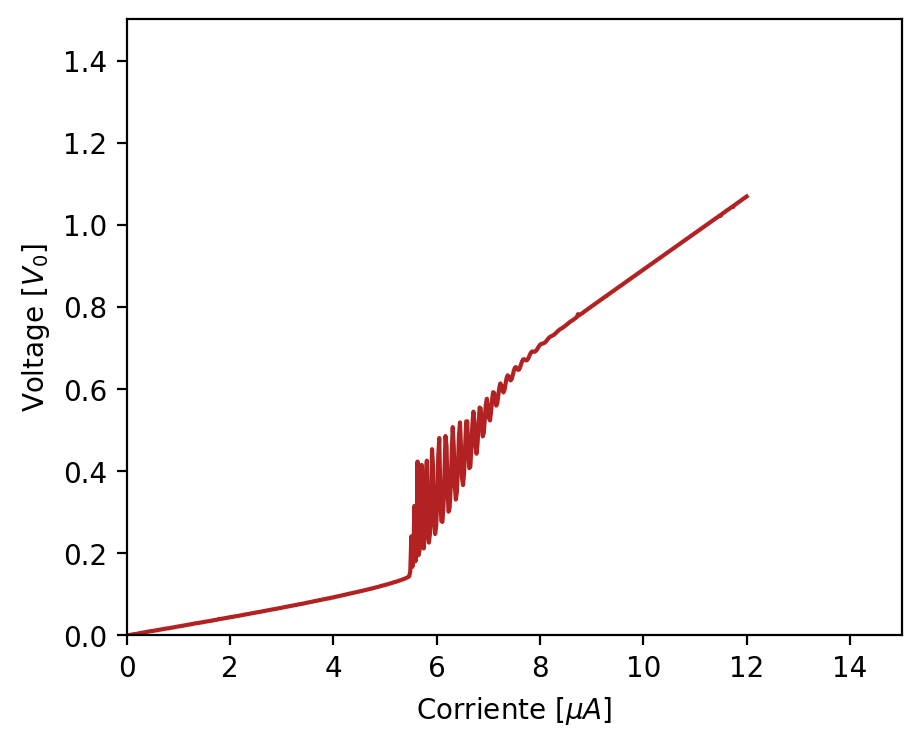

In [ ]:
output_dir = Path("../datasets/series2")
output_dir.mkdir(exist_ok=True)

voltage_values = np.zeros(len(voltages))
plt.figure(figsize=(5, 4), dpi=200)
pair = [0, 1]

for idx in range(len(voltages)):
    vtrace = voltages[idx]
    if vtrace is None and solutions[idx] is not None:
        vtrace = solutions[idx].dynamics.voltage(pair[0], pair[1])
    if vtrace is None:
        continue
    max_idx = vtrace.shape[0] - 1
    voltage_values[idx] = np.mean(vtrace[max_idx])
    data_series = np.vstack((times[idx], vtrace))
    np.save(output_dir / f"output_{idx}.npy", data_series)

plt.plot(currents, voltage_values, color="firebrick")
plt.xlabel("Corriente [$\mu A$]")
plt.ylabel("Voltage [$V_0$]")
plt.xlim(0, 15)
plt.ylim(0, 1.5)

## Voltage Time Traces
Plot selected bias points vs time for diagnostics.

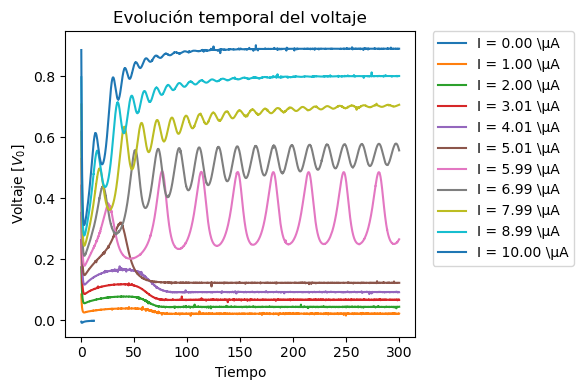

In [ ]:
target_currents = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
indices = [np.abs(currents - val).argmin() for val in target_currents]

plt.figure(figsize=(6, 4))
for idx, val in zip(indices, target_currents):
    vtrace = voltages[idx]
    ttrace = times[idx]
    if vtrace is None or ttrace is None:
        continue
    plt.plot(ttrace, vtrace, label=f"I = {currents[idx]:.2f} \μA")
plt.xlabel("Tiempo")
plt.ylabel("Voltaje [$V_0$]")
plt.title("Evolución temporal del voltaje")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0)
plt.tight_layout()